# Buiding a CNN on MNIST Dataset

This project requires you to install [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org). Keras is a high-level Deep Learning API, written in Python using TensorFlow, CNTK, or Theano as back-ends. Here, we will use Tensorflow as back-end.


## Installation
Instructions can be found here:
* [Keras](https://keras.io)
* [Tensorflow](https://www.tensorflow.org/install/)

If you're using a virtualenv:
```
pip3 install keras
```
and 
```
pip3 install tensorflow
```
Add ```sudo``` for a systemwide installation (i.e. no ```virtualenv```).
```
sudo pip3 install keras
```
and 
```
sudo pip3 install tensorflow
```

## Understanding the model

### Optimizers

Loss is the penalty for a bad prediction. That is, loss is a number indicating how bad the model's prediction was on a single example. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater than zero. The goal of training a model is to find a set of weights and biases (i.e. parameters) that have, on average, a low loss across all examples. The term cost is used interchangably with loss. See the [loss section](https://keras.io/losses/) in the Keras documentation for a list and descriptions of what is available.

<img src="./LossSideBySide.png" width="500">
<figcaption>Figure. Left: high loss and right: low loss.</figcaption>

The optimizer is the algorithm used to minimize the loss/cost. Optimizers in neural networks work by finding the gradient/derivative of the loss with respect to the parameters (i.e. the weights). "Gradient" is the correct term since a we are looking at multi-dimensional systems (i.e. many parameters), however, the terms are often used interchangably. For those who didn't take multivariable calculus, just think of the gradient as a derivative. The derivative of the loss with respect to a parameters tells us how much the loss changes when we nudge a weight up or down. So, by knowing how a given parameter affects the loss the optimizer can change it so as to decrease the loss. The various optimizers differ in how they change the weights. 

#### Mini-overview over popular optimizers

* **Stochastic Gradient Descent (SGD)**. This is the most basic and easy to understand optimizer. It updates the weights in the negative direction of the gradient by taking the average gradient of mini-batch of data (e.g. 20-50 exemplars) in each step. Vanilla SGD only has one hyper-parameter, the learning rate.
* **Momentum**. This optimizer "gains speed" when the gradient has pointed in the same direction for several consecutive updates. That is, it gains momentum. It does this by accumulating an exponentially decaying moving average of past gradients. The step size depends on how large and aligned the sequence of gradients are. The most important hyper-parameter is alpha and common values are 0.5 and 0.9.
* **Nesterov Momentum**. This is a modification of the standard momentum optimizer.
* **AdaGrad**. This optimizer Ada-ptively sets the learning rate depending on the steepness/magnitude of the Grad-ients. This is done so that weights with big gradients get a smaller effective learning rate, and weights with small gradients will get a greater effective learning rate. The result is quicker progress in the more gently sloped directions of the weight space and a slowdown in stepp regions.
* **RMSProp**. This is modification of AdaGrad, where the accumulated gradient decays, that is, the influence of previous gradients gradually decreases.
* **Adam**. The name comes from "adaptive moments", and it is a combination of RMSProp and momentum. It has several hyper-parameters.

The above list just gives a quick overview of some of the most common. However, old optimizers are constantly improved and new are developed. SGD and momentum are most basic and easiest to understand and implement. They are still in use, but the more advanced optimizers tend to be better for practical use. Which one to use is generally an emperical question depending on both the data and the model.

For a more complete overview of optimization algorithms see [this comparison](http://ruder.io/optimizing-gradient-descent/), and to see what is available in Keras, see the [optimizer section](https://keras.io/optimizers/) of the documentation.

See the images below for a comparison of optimizers in a 2D space (NAG: Nesterov accelerated gradient, Adadelta: an extension of AdaGrad).

<img src="./contours_evaluation_optimizers.gif" width="500">
<img src="./saddle_point_evaluation_optimizers.gif" width="500">

In [2]:
# imports
import numpy as np
#from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# for the random seed
import tensorflow as tf

# set the random seeds to get reproducible results
np.random.seed(1)
tf.set_random_seed(2)

# Load data from https://www.openml.org/d/554
#X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

tmp = np.load('mnist.npz')
X = tmp['X']
y = tmp['y']

X, y = X[:1000], y[:1000]
X = X.reshape(X.shape[0], 28, 28, 1)
# Normalize
X = X / 255.
# number of unique classes
num_classes = len(np.unique(y))
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

num_tot = y.shape[0]
num_train = y_train.shape[0]
num_test = y_test.shape[0]

y_oh = np.zeros((num_tot, num_classes))
y_oh[range(num_tot), y] = 1

y_oh_train = np.zeros((num_train, num_classes))
y_oh_train[range(num_train), y_train] = 1

y_oh_test = np.zeros((num_test, num_classes))
y_oh_test[range(num_test), y_test] = 1

### The Dataset

 * ```X``` and ```y``` are numpy arrays, ```X``` contains the pixel intensities in each training image and ```y``` contains the class numbers (digits 0 to 9). 
 * Each element of the original array ```X``` is a vector of 784 elements.
 * Array ```y``` contains a number representing the digit in the image. 
 * ```X = X.reshape(X.shape[0], 28, 28, 1)``` reshapes the ```X``` instances into an image format with ```28*28``` pixels as height and width. The depth of this data is 1. 
 * ```y``` is a 1000 dimentional vector containing integers, but ```y_oh[range(num_tot), y] = 1``` converts it to a one-hot-enconding format. 
 * In each row of ```y_oh``` only one column is equal to 1, that is the column corresponding to the class number (0-9) 
 * One-hot-encoding provides a format suitable to use by classification algorithms that use corss-entropy cost function.

In [4]:
# y_oh is the one-hot encoded version of y, for examples:
print(y[10], y_oh[10]) 

3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [5]:
print(y[20], y_oh[20])

4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


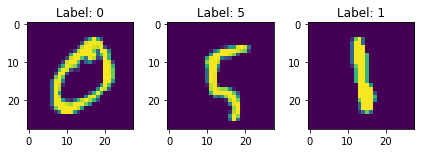

In [6]:
# Plotting 3 examples with their labels:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(np.squeeze(X[1]))
ax1.set_title('Label: ' + str(y[1]))
ax2.imshow(np.squeeze(X[100]))
ax2.set_title('Label: ' + str(y[100]))
ax3.imshow(np.squeeze(X[200]))
ax3.set_title('Label: ' + str(y[200]))
fig.tight_layout()

### The model

Here is some explanation about the model and different parts of it. Below is some code for building and training a model with Keras. 
* We will train a CNN (convolutional Neural Network)
* We will use Relu activation function for the 3 hidden layers
* Softmax activation is used for the output layer
* Relu is typically used for the hidden layers for its mathematical and numerical properties that makes optimization efficient. It also avoids the vanishing gradient problem. Softmax is used for output because we are solving a multi-class classification problem for which softmax returns class membership probabilities (between 0 and 1)
* The first optimization method we will use is mini-batch gradient descent with Nesterov momentum 
* We will use a mini-batch size of 32
* The loss function is cross-entropy
* The number of parameters in the model is 108,618: <br>
    * Conv layer 1: input size: 28 x 28 x 1, filter size: 3 x 3 x 16 so the number of parameters in this layer is: 3 x 3 x 1 x 16 + 16 = 160. Output size is: 26 x 26 x 16 
    * Conv layer 2: input size (after pooling the last layer): 13 x 13 x 16, filter size: 3 x 3 x 32 so the number of parameters in this layer is: 3 x 3 x 16 x 32 + 32 = 4,640. Output size is: 11 x 11 x 32 
    * Dense layer: input size (after pooling) is 5 x 5 x 32 and next layer size is 128, so the number of parameters to learn is: 800 * 128 + 128 = 102,528
    * For the output layer, the number of parameters to learn is: 128 * 10 + 10 = 1,290
    * So, the total number of parameters to learn: 160 + 4,640 + 10,2528 + 1,290 = 108,618

In [107]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD


model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.))

model.add(Conv2D(32, (3, 3), activation='relu'))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.))

model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=sgd)

# Saving the initial random weights in the model for further use later
Initial_weights = model.get_weights()

# Train the model
model.fit(X_train, y_oh_train, batch_size=32, epochs=60)

# Evaluate performance
test_loss = model.evaluate(X_test, y_oh_test, batch_size=32)

predictions = model.predict(X_test, batch_size=32)
predictions = np.argmax(predictions, axis=1) # change encoding again
print('Accuracy:', (predictions == y_test).sum() / predictions.shape[0])

Epoch 1/60
800/800 [==============================] - 7s 9ms/step - loss: 2.2435
Epoch 2/60
800/800 [==============================] - 1s 2ms/step - loss: 1.4684
Epoch 3/60
800/800 [==============================] - 1s 2ms/step - loss: 0.7015
Epoch 4/60
800/800 [==============================] - 1s 2ms/step - loss: 0.4090
Epoch 5/60
800/800 [==============================] - 2s 2ms/step - loss: 0.3176
Epoch 6/60
800/800 [==============================] - 1s 2ms/step - loss: 0.2409
Epoch 7/60
800/800 [==============================] - 1s 2ms/step - loss: 0.1913
Epoch 8/60
800/800 [==============================] - 2s 2ms/step - loss: 0.1621
Epoch 9/60
800/800 [==============================] - 2s 2ms/step - loss: 0.1400
Epoch 10/60
800/800 [==============================] - 1s 2ms/step - loss: 0.1116
Epoch 11/60
800/800 [==============================] - 1s 2ms/step - loss: 0.0771
Epoch 12/60
800/800 [==============================] - 2s 2ms/step - loss: 0.0636
Epoch 13/60
800/800 [====

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               102528    
__________

In [9]:
test_loss

0.33982968986034395

## Training a model

A model's performance depends on many factors apart from the model architecture (e.g. type and number of layers) and the dataset. Here you will get to explore some of the factors that affect model performance. Much of the skill in training deep learning models lies in quickly finding good values/options for these choises.

In order to observe the learning process it is best to compare the training set loss with the loss on the test set. How to visualize these variables in Keras is described under [Training history visualization](https://keras.io/visualization/#training-history-visualization) in the documentation.

You will explore the effect of 1) optimizer, 2) training duration, and 3) dropout.

When training, an **epoch** is one pass through the full training set.

* **Vizualize the training**. We will use the model above to observe the training process. Train it for 150 epochs and then plot both "loss" and "val_loss" (i.e. loss on the valiadtion set, here the terms "validation set" and "test set" are used interchangably, but this is not always true).
    * As can be seen from the plot, with 7 to 8 epochs we get the minimum value of the loss function

* **Optimizer**. We select three different optimizers (Momentum, RMSProp, and Adam) and for each find the close-to-optimal hyper-parameter(s). We will train the model for long enough to reach optimal performance.

* **Dropout**. We will use the best optimizer and do hyper-parameter seach and find the best value for ```Dropout()```. 

* **Best model**. We will combine what we learned from above to build the best model.

* **A Note on the Results**. 
    * The data should be split into three parts, train, validation, and test. The validation set should be used for the purpose of hyperparameter tuning and test set should be used for final model evaluation. In this project we used one set for both validation and test, however the final model performance should only be evaluated on unseen data (test set). The performance of the model on the validation set is not representative of the performance one would expect on a previously unseen data as the model might have adapted too well to this data and not generalize well to unseen data.

In [108]:
# Visualize the training history

# We use the initial random weights that we saved before to prevent the model to continue from where it stopped
model.set_weights(Initial_weights)

# Creating the training history to plot the training curve
# Here we use X_train and y_oh_train to train the model, and X_test, y_oh_test for validation
history = model.fit(X_train, y_oh_train, validation_data=(X_test, y_oh_test), epochs=150, batch_size=32, verbose=0)

<IPython.core.display.Javascript object>


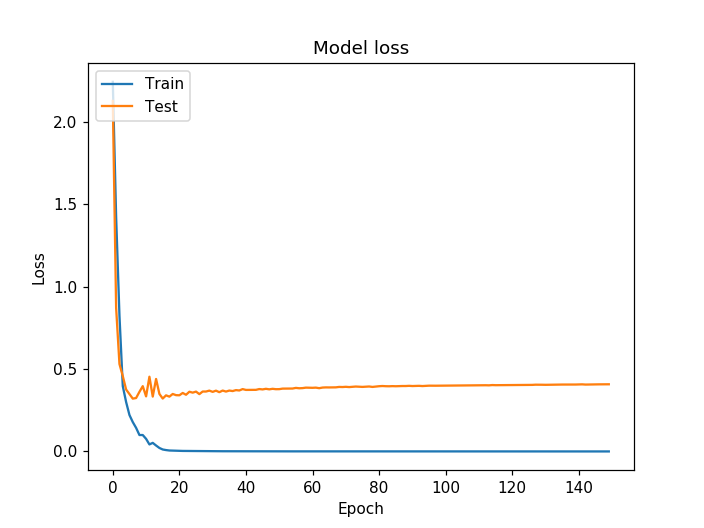

In [109]:
# Plotting the training & validation loss values
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Hyerparameter Search 
* We consider 3 optimizers: SGD with Nesterov momentum, RMSProp and ADAM
* On each one we will do a hyperparameters grid search  

In [15]:
from keras.optimizers import RMSprop, Adam, SGD
import itertools

# Training a minibatch SGD with Nesterov momentum (and without momentum in the case of momentum=0)
# We will train for 50 epochs and choose choose an epoch that gives the lowest val-loss  

lr_list = [0.1, 0.01, 0.001]
decay_list = [1e-6, 1e-4]
momenum_list = [0, 0.5, 0.9, 0.99]
grid = [lr_list, decay_list, momenum_list]

print("{:<14} {:<14} {:<14} {:<14} {:<14}".format('Learning-Rate', 'Decay', 'Momentum', 'Optimum-Epoch', 'Val-Loss'))

for lr, decay, momentum in itertools.product(*grid):
    sgd = SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd)
    model.set_weights(Initial_weights)
    history = model.fit(X_train, y_oh_train, validation_data=(X_test, y_oh_test), epochs=50, batch_size=32, verbose=0)
    best_epoch = np.argsort(history.history['val_loss'])[0]
    print("{:<14} {:<14} {:<14} {:<14} {:<14}".format(lr, decay, momentum, best_epoch, 
                                                      history.history['val_loss'][best_epoch])) 

Learning-Rate  Decay          Momentum       Optimum-Epoch  Val-Loss      
0.1            1e-06          0              14             0.3021601974964142
0.1            1e-06          0.5            5              0.30688676714897156
0.1            1e-06          0.9            0              14.58687614440918
0.1            1e-06          0.99           1              1.3012768507003785
0.1            0.0001         0              4              0.3367884016036987
0.1            0.0001         0.5            4              0.4010323405265808
0.1            0.0001         0.9            17             0.5520852029323577
0.1            0.0001         0.99           0              13.700381317138671
0.01           1e-06          0              46             0.3098188829421997
0.01           1e-06          0.5            31             0.2941291284561157
0.01           1e-06          0.9            8              0.2575499439239502
0.01           1e-06          0.99           7          

* According to above results, for this choice of optimizer the optimal hyperparameters are $\alpha=0.01$, decay=1e-06, $\beta=0.9$. 

    * Note that for $\alpha=0.001$ in many cases more than 50 epochs was required to get the minimum test loss, but we didn't train the model longer than 50 epochs in this project. Also, for $\alpha=0.1$ in a couple of cases the algorithm diverges.

In [16]:
# Training a minibatch SGD with RMSProp

lr_list = [0.1, 0.01, 0.001]
rho_list = [0.5, 0.9, 0.99]
grid = [lr_list, rho_list]

print("{:<14} {:<14} {:<14} {:<14}".format('Learning-Rate', 'Rho', 'Optimum-Epoch', 'Val-Loss'))

for lr, rho in itertools.product(*grid):
    rmsprop = RMSprop(lr=lr, rho=rho, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=rmsprop)
    model.set_weights(Initial_weights)
    history = model.fit(X_train, y_oh_train, validation_data=(X_test, y_oh_test), epochs=50, batch_size=32, verbose=0)
    best_epoch = np.argsort(history.history['val_loss'])[0]
    print("{:<14} {:<14} {:<14} {:<14}".format(lr,rho, best_epoch, history.history['val_loss'][best_epoch])) 

Learning-Rate  Rho            Optimum-Epoch  Val-Loss      
0.1            0.5            0              14.828647384643554
0.1            0.9            0              14.828647384643554
0.1            0.99           0              14.82864761352539
0.01           0.5            3              0.306996381431818
0.01           0.9            7              0.29411319360136984
0.01           0.99           0              14.50628589630127
0.001          0.5            9              0.3241797381639481
0.001          0.9            7              0.260179300904274
0.001          0.99           9              0.2727255392074585


* According to above results, the best hyperparameters for this optimizer are $\alpha=0.001, \rho=0.9$.

In [17]:
# Training a minibatch SGD with ADAM 

lr_list = [0.1, 0.01, 0.001]
beta1_list = [0.9, 0.99]
beta2_list = [0.99, 0.999]

grid = [lr_list, beta1_list, beta2_list]

print("{:<14} {:<14} {:<14} {:<14} {:<14}".format('Learning-Rate', 'Beta1', 'Beta2', 'Optimum-Epoch', 'Val-Loss'))

for lr, beta1, beta2 in itertools.product(*grid):
    adam = Adam(lr=lr, decay=1e-6, beta_1=beta1, beta_2=beta2)
    model.compile(loss='categorical_crossentropy', optimizer=adam)
    model.set_weights(Initial_weights)
    history = model.fit(X_train, y_oh_train, validation_data=(X_test, y_oh_test), epochs=50, batch_size=32, verbose=0)
    best_epoch = np.argsort(history.history['val_loss'])[0]
    print("{:<14} {:<14} {:<14} {:<14} {:<14}".format(lr,beta1, beta2, best_epoch, history.history['val_loss'][best_epoch])) 

Learning-Rate  Beta1          Beta2          Optimum-Epoch  Val-Loss      
0.1            0.9            0.99           0              14.828647384643554
0.1            0.9            0.999          0              14.26451416015625
0.1            0.99           0.99           0              13.86156192779541
0.1            0.99           0.999          0              14.82864761352539
0.01           0.9            0.99           3              0.2955042111873627
0.01           0.9            0.999          12             0.2395530465245247
0.01           0.99           0.99           7              0.3426368288137019
0.01           0.99           0.999          6              0.29598987817764283
0.001          0.9            0.99           11             0.26922361642122267
0.001          0.9            0.999          9              0.2760219639539719
0.001          0.99           0.99           12             0.2876123055815697
0.001          0.99           0.999          11          

Among the optimizers and the hyperparameters used, the ADAM optimizer with the hyperparameters $\alpha=0.01, \beta1=0.9, \beta2=0.999$ is the optimal choice.

In [22]:
# Hyperparameter search for best dropout rates

# Dropout rates for layer 1 and layer 2
dropout_rate1 = [0, 0.1, 0.2, 0.3]
dropout_rate2 = [0, 0.2, 0.3, 0.5]

grid = [dropout_rate1, dropout_rate2]
adam = Adam(lr=0.01, decay=1e-6, beta_1=0.9, beta_2=0.999)

print("{:<14} {:<14} {:<14} {:<14}".format('Dropout 1', 'Dropout 2', 'Optimum-Epoch', 'Val-Loss'))

for rate1, rate2 in itertools.product(*grid):
    model.layers[2].rate = rate1
    model.layers[7].rate = rate2
    model.compile(loss='categorical_crossentropy', optimizer=adam)
    #test if the dropout rates are set correctly
    #print(model.layers[2].rate, model.layers[7].rate)
    model.set_weights(Initial_weights)
    history = model.fit(X_train, y_oh_train, validation_data=(X_test, y_oh_test), epochs=50, batch_size=32, verbose=0)
    best_epoch = np.argsort(history.history['val_loss'])[0]
    print("{:<14} {:<14} {:<14} {:<14}".format(rate1, rate2, best_epoch, history.history['val_loss'][best_epoch]))

Dropout 1      Dropout 2      Optimum-Epoch  Val-Loss      
0              0              5              0.2309096086025238
0              0.2            0              14.828647537231445
0              0.3            8              2.308589038848877
0              0.5            0              14.82864761352539
0.1            0              0              14.828647537231445
0.1            0.2            0              14.50628589630127
0.1            0.3            0              2.3062304782867433
0.1            0.5            0              14.183923835754394
0.2            0              2              2.3042988395690918
0.2            0.2            3              2.308283176422119
0.2            0.3            27             2.3075725173950197
0.2            0.5            2              2.3040523147583007
0.3            0              5              2.3077409744262694
0.3            0.2            4              0.5000449681282043
0.3            0.3            2              2.3

* As can be seen from above results, dropout did not improve the validation loss.

* Finally, we can check the accuracy of the model we have optimized:

In [97]:
adam = Adam(lr=0.01, decay=1e-6, beta_1=0.9, beta_2=0.999)

model.compile(loss='categorical_crossentropy', optimizer=adam)

history = model.fit(X_train, y_oh_train, validation_data=(X_test, y_oh_test), epochs=5, batch_size=32, 
                    verbose=1)

predictions = model.predict(X_test, batch_size=32)
predictions = np.argmax(predictions, axis=1) # change encoding again
print('Accuracy:', (predictions == y_test).sum() / predictions.shape[0])

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 8s 10ms/step - loss: 0.1706 - val_loss: 0.4024
Epoch 2/5
800/800 [==============================] - 2s 3ms/step - loss: 0.0852 - val_loss: 0.2095
Epoch 3/5
800/800 [==============================] - 2s 2ms/step - loss: 0.0468 - val_loss: 0.2678
Epoch 4/5
800/800 [==============================] - 2s 2ms/step - loss: 0.0262 - val_loss: 0.3058
Epoch 5/5
800/800 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.2669
Accuracy: 0.95
